In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import hashlib 

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 8)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Множественное тестирование
## 1.1. FWER - групповая вероятность ошибки первого рода
Посмотрим как меняется FWER при увеличении кол-ва экспериментов
$$FWER = \mathbb{P}(FP > 0)$$
$FP$ - число ложно положительных результатов

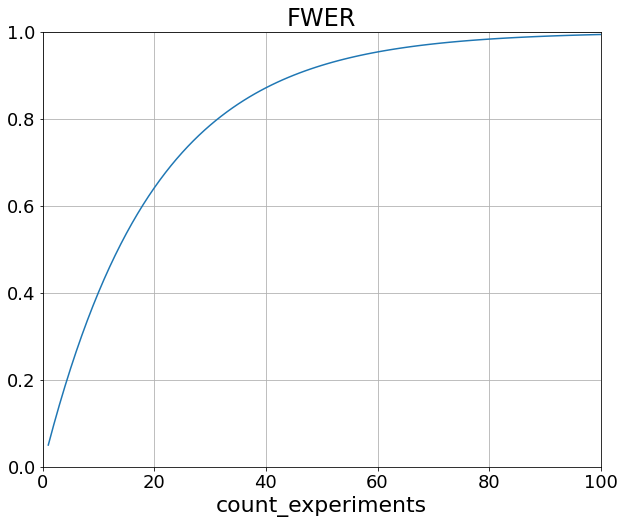

In [3]:
alpha = 0.05

count_experiments = np.arange(1, 101)
array_fwer = 1 - (1 - alpha) ** count_experiments

plt.plot(count_experiments, array_fwer, '-')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.xlabel('count_experiments')
plt.title('FWER')
plt.show()

При увеличении кол-ва экспериментов, вероятность допустить хоть одну ошибку I рода быстро увеличивается.

### 1.1.1 Метод Бонферрони
Пусть у нас есть N АА-тестов. Сгенерируем N pvalue из равномерного распределения на [0, 1], предполагая, что верна нулевая гипотеза о равенстве средних. Запомним есть ли среди этих N тестов ошибки I рода. Повторим эту процедуру много раз, чтобы оценить FWER.

In [4]:
np.random.seed(125)

alpha = 0.05
size = 50

list_pvalues = [np.random.rand(size) for _ in range(1000)]
res = [int((pvalues <= alpha).sum() > 0) for pvalues in list_pvalues]
print(f'FWER без поправок: {np.mean(res):0.3f}')

FWER без поправок: 0.916


Применим метод Бонферрони к сгенерированным pvalue.

In [5]:
def method_bonferroni(pvalues, alpha=0.05):
    """Применяет метод Бонферрони для проверки значимости изменений.
  
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    alpha_ = alpha / m
    res = (np.array(pvalues) <= alpha_).astype(int)
    return res


res_bonferroni = [int(np.sum(method_bonferroni(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Бонферрони: {np.mean(res_bonferroni):0.3f}')

FWER с поправкой Бонферрони: 0.042


Получили FWER не превышающее значение alpha.

Есть готовая реализация функция для работы с множественным тестирование, которая корректирует pvalue.

Сравним результаты

In [6]:
from statsmodels.sandbox.stats.multicomp import multipletests 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
multipletests(list_pvalues[0], alpha=alpha, method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.45381296, 1.        , 1.        , 0.11647981,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 

In [8]:
np.clip(list_pvalues[0] * size, 0, 1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.45381296, 1.        , 1.        , 0.11647981,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Функция выдаёт скорректированные $pvalue^* = min([1, pvalue \times size])$, что эквивалентно сравнению исходного pvalue с порогом $\dfrac{\alpha}{size}$.

In [9]:
res_bonferroni = [
    int(True in multipletests(pvalues, alpha=alpha, method='bonferroni')[0])
    for pvalues in list_pvalues
]
print(f'FWER с поправкой Бонферрони: {np.mean(res_bonferroni):0.3f}')

FWER с поправкой Бонферрони: 0.042


Получили такой же результат

### 1.1.2. Метод Холма

In [10]:
def method_holm(pvalues, alpha=0.05):
    """Применяет метод Холма для проверки значимости изменений.
  
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    array_alpha = np.arange(m, 0, -1)
    array_alpha = alpha / array_alpha
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue < alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

In [11]:
res_holm = [int(np.sum(method_holm(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Холма: {np.mean(res_holm):0.3f}')

FWER с поправкой Холма: 0.042


Сравним с функцией из statmodels.

In [12]:
res_holm = [
    int(True in multipletests(pvalues, alpha=alpha, method='holm')[0])
    for pvalues in tqdm(list_pvalues)
]
print(f'FWER с поправкой Холма: {np.mean(res_holm):0.3f}')


FWER с поправкой Холма: 0.042


### 1.1.3. Метод Бенджамини-Хохберга

In [13]:
def method_benjamini_hochberg(pvalues, alpha=0.05):
    """Применяет метод Бенджамини-Хохберга для проверки значимости изменений.
    
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    array_alpha = np.arange(1, m+1)
    array_alpha = alpha * array_alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

In [14]:
res_bh = [int(np.sum(method_benjamini_hochberg(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Бенджамини-Хохберга: {np.mean(res_bh):0.3f}')

FWER с поправкой Бенджамини-Хохберга: 0.042


Когда все эксперименты без эффекта, ошибки первого рода практически совпадают на этих данных.

### 1.1.4. Сравнение методов.
Будем увеличивать кол-во экспериментов и считать долю "прокрасившихся" экспериментов среди экспериментов без эффекта (ошибка I рода) и доля "непрокрисившихся" среди экспериментов с эффектом (ошибка II рода).

Затем посмотрим как меняются:
- FWER;
- $\mathbb{P}(FN > 0)$ --- аналог FWER для ошибок II рода, вероятность хоть одного эксперимента с FN;
- FDR --- средняя доля ложных отклонений гипотез среди всех отклонений.

In [15]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

    
def method_baseline(pvalues, alpha=0.05):
    """Проверет значимость без поправок.
    
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    res = (np.array(pvalues) <= alpha).astype(int)
    return res

In [16]:
def plot_metrics(dict_method_error, graph_types, count_pilots=None):
    """Строит графики метрик: FWER, P(FN > 0), FDR.
    
    :param dict_method_error: dict, словарь с ошибками методов. Пример,
        {
            'holm': { # название метода
                100: { # число экспериментов, если count_pilots==None, иначе число экспериментов с эффектом
                    'part_first_type_error': [0.2, ...], # списки ошибок I и II рода
                    'part_second_type_error': [0.2, ...],
                }
            }
        }
    :param graph_types: List[str], список типов графиков, которые нужно построить.
        Возможные значения: ['FWER', 'P(FN > 0)', 'FDR'].
    :param count_pilots: int or None, если int - общее кол-во экспериментов среди которых есть с эффектом и без эффекта.
    """
    available_graph_types = ['FWER', 'P(FN > 0)', 'FDR']
    method_config = {'baseline': ['-o'], 'bonferroni': ['-v'], 'holm': ['-<'], 'benjamini_hochberg': ['->']}

    fig, axes = plt.subplots(1, len(available_graph_types), figsize=(24, 6))

    for graph_type in graph_types:
        assert graph_type in available_graph_types, f'graph_type "{graph_type}" not available.'

    for method_name, dict_errors in dict_method_error.items():
        X = []
        dict_Y = {graph_type: [] for graph_type in graph_types}
        for count_pilot, dict_ in dict_errors.items():
            X.append(count_pilot)
            if 'FWER' in graph_types:
                dict_Y['FWER'].append(np.mean(np.array(dict_['part_first_type_error']) > 0))
            if 'P(FN > 0)' in graph_types:
                dict_Y['P(FN > 0)'].append(np.mean(np.array(dict_['part_second_type_error']) > 0))
            if ('FDR' in graph_types) and (count_pilots is not None):
                fp = np.array(dict_['part_first_type_error']) * (count_pilots - count_pilot)
                tp = (1 - np.array(dict_['part_second_type_error'])) * count_pilot
                fp_tp = fp + tp
                fp_tp[fp_tp < 1] = 1
                dict_Y['FDR'].append(np.mean(fp / fp_tp))
        for graph_type, Y in dict_Y.items():
            idx = available_graph_types.index(graph_type)
            if graph_type in graph_types:
                axes[idx].plot(X, Y, method_config[method_name][0], label=method_name, alpha=0.7)

    max_X = np.max(X)
    if 'FWER' in graph_types:
        axes[0].hlines(0.05, 0, max_X, 'k', linestyles='--', label='alpha=0.05')
    if 'P(FN > 0)' in graph_types:
        axes[1].hlines(0.2, 0, max_X, 'k', linestyles='--', label='beta=0.20')
    if 'FDR' in graph_types:
        axes[2].hlines(0.05, 0, max_X, 'k', linestyles='--', label='alpha=0.05')

    for graph_type, ax in zip(available_graph_types, axes):
        ax.set_title(graph_type)
        ax.set_xlabel('count experiment with effect' if count_pilots else 'count experiment')
        if graph_type in graph_types:
            ax.legend()


In [17]:
dict_methods = {
    'baseline': method_baseline,
    'bonferroni': method_bonferroni,
    'holm': method_holm,
    'benjamini_hochberg': method_benjamini_hochberg
}

#### Без эффекта

In [18]:
count_pilots = 100
group_size = 50
effect_size = 0.0
mean_ = 10
std_ = 1
n_iter = 500


np.random.seed(43)

list_count_pilot = [1] + list(range(10, count_pilots, 10)) + [count_pilots - 1]
dict_method_error = {
    method_name: {
        count_pilot: {
            'part_first_type_error': [], 'part_second_type_error': []
        }
        for count_pilot in list_count_pilot
    }
    for method_name in dict_methods
}


for count_pilot in tqdm(list_count_pilot):
    # проведём несколько итераций для набора статистики и оценки FWER
    for _ in range(n_iter):
        # data experiments without effect
        list_data = [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_, std_, group_size)
            )
            for _ in range(count_pilot)
        ]
        pvalues = [
            stats.ttest_ind(data_pilot, data_control)[1]
            for data_pilot, data_control in list_data
        ]
        for method_name, method in dict_methods.items():
            result_experiments = method(pvalues)
            dict_method_error[method_name][count_pilot]['part_first_type_error'].append(
                np.mean(result_experiments)
            )

Для экспериментов без эффекта имеет смысл смотреть только FWER, так как без экспериментов с эффектом FN и TP всегда равны нулю.

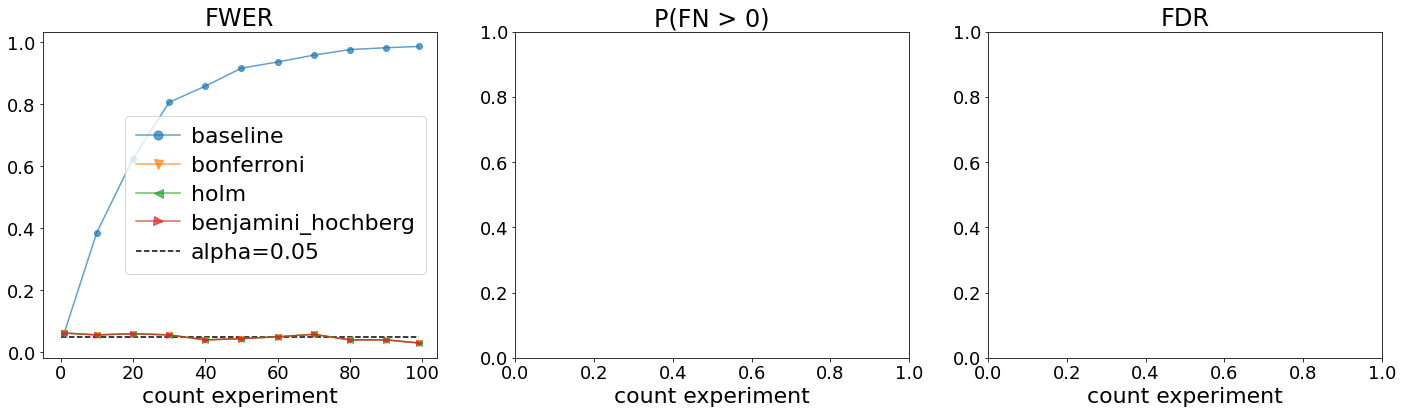

In [19]:
plot_metrics(dict_method_error, ['FWER'])

Для АА-тестов baseline проигрывает всем методам корректировок для множественного тестирования с точки зрения контроля FWER.

#### C эффектом

In [20]:
count_pilots = 100
group_size = 50
effect_size = 0.056
mean_ = 10
std_ = 1
n_iter = 500

mde = get_minimal_determinable_effect(std_, group_size, alpha=0.05, beta=0.2)
print(f'MDE = {mde:0.2f}')

MDE = 0.56


In [21]:
np.random.seed(43)

list_count_pilot = [1] + list(range(5, 21, 5))
dict_method_error = {
    method_name: {
        count_pilot: {
            'part_first_type_error': [], 'part_second_type_error': []
        }
        for count_pilot in list_count_pilot
    }
    for method_name in dict_methods
}


for count_pilot in tqdm(list_count_pilot):
    # проведём несколько итераций для набора статистики и оценки FWER
    for _ in range(n_iter):
        # data experiments with effect
        list_data = [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_ * (1 + effect_size), std_, group_size)
            )
            for _ in range(count_pilot)
        ]
        pvalues = [
            stats.ttest_ind(data_pilot, data_control)[1]
            for data_pilot, data_control in list_data
        ]
        for method_name, method in dict_methods.items():
            result_experiments = method(pvalues)
            dict_method_error[method_name][count_pilot]['part_second_type_error'].append(
                1 - np.mean(result_experiments)
            )

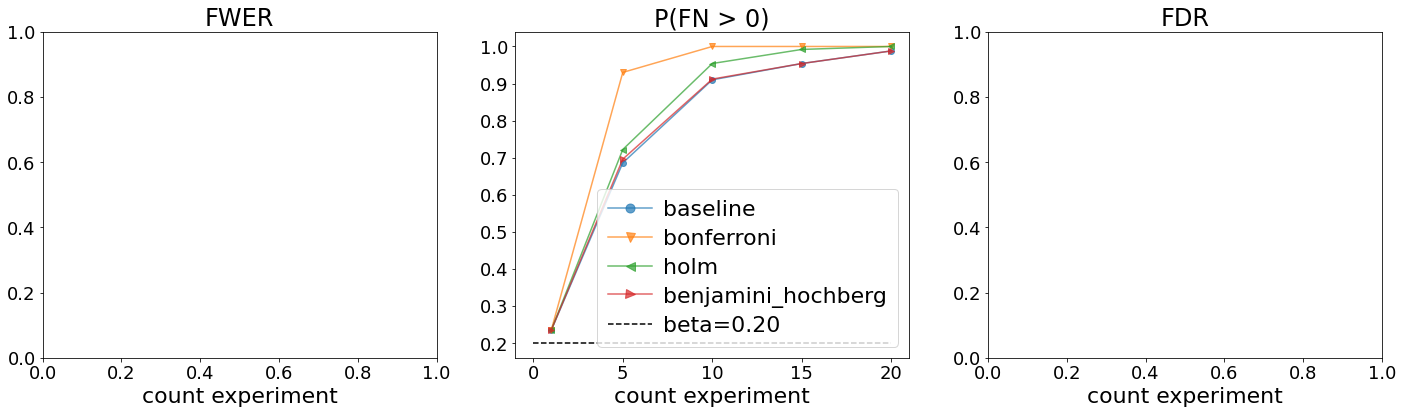

In [22]:
plot_metrics(dict_method_error, ['P(FN > 0)'])

Доля групп экспериментов с FN > 0 быстро растёт для всех методов. Чем консервативнее метод, тем быстрее растёт $\mathbb{P}(FN > 0)$ с ростом числа экспериментов.

#### Смесь экспериментов с эффектом и без эффекта

In [23]:
count_pilots = 100
group_size = 50
effect_size = 0.1
mean_ = 10
std_ = 1
n_iter = 500


mde = get_minimal_determinable_effect(std_, group_size, alpha=0.05, beta=0.2)
print(f'MDE = {mde:0.2f}')

MDE = 0.56


In [24]:
np.random.seed(43)


list_count_pilot_with_effect = [1] + list(range(10, count_pilots, 10)) + [count_pilots - 1]
dict_method_error = {
    method_name: {
        count_pilot_with_effect: {
            'part_first_type_error': [], 'part_second_type_error': []
        }
        for count_pilot_with_effect in list_count_pilot_with_effect
    }
    for method_name in dict_methods
}


for count_pilot_with_effect in tqdm(list_count_pilot_with_effect):
    count_pilot_without_effect = count_pilots - count_pilot_with_effect

    # проведём несколько итераций для набора статистики и оценки FWER
    for _ in range(n_iter):
        # data experiments without effect
        list_data = [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_, std_, group_size)
            )
            for _ in range(count_pilot_without_effect)
        ]
        # add data experiments with effect
        list_data += [
            (
                np.random.normal(mean_, std_, group_size),
                np.random.normal(mean_ * (1 + effect_size), std_, group_size)
            )
            for _ in range(count_pilot_with_effect)
        ]
        pvalues = [
            stats.ttest_ind(data_pilot, data_control)[1]
            for data_pilot, data_control in list_data
        ]
        for method_name, method in dict_methods.items():
            result_experiments = method(pvalues)
            dict_method_error[method_name][count_pilot_with_effect]['part_first_type_error'].append(
                np.mean(result_experiments[:count_pilot_without_effect])
            )
            dict_method_error[method_name][count_pilot_with_effect]['part_second_type_error'].append(
                1 - np.mean(result_experiments[count_pilot_without_effect:])
            )

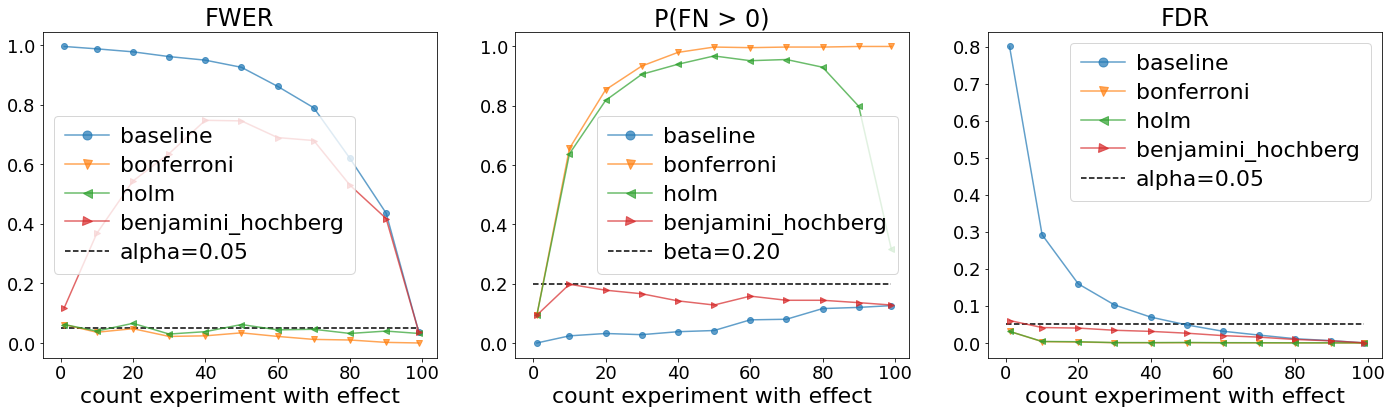

In [25]:
plot_metrics(dict_method_error, ['FWER', 'P(FN > 0)', 'FDR'], count_pilots)

FWER:
- **baseline** допускает ошибки I рода почти в 100% случаях, когда 100 экспериментов без эффекта, затем при уменьшении кол-ва экспериментоа ошибка падает до 0.05;
- **bonferroni** контролируют FWER на уровне 0.05 когда все эксперименты без эффекта, при увеличении кол-ва экспериментов с эффектом FWER снижается;
- **holm** контролируют FWER на уровне 0.05;
- **benjamini_hochberg** занимает прмежуточное состояние между baseline и holm.

$\mathbb{P}(FN > 0)$:
- **baseline** допускает меньше других ошибки II рода;
- **bonferroni** чаще других ошибочно отвергает эксперименты с эффектом;
- **holm** при небольшом кол-ве экспериментов с эффектом вероятность ошибок II рода похожа на bonferroni;
- **benjamini_hochberg** занимает прмежуточное состояние между baseline и holm.

FDR:
- **benjamini_hochberg** лучше других контролирует FDR на уровне 0.05

#### Средняя доля ошибок
Посмотрим как меняется средняя доля ошибок первого и второго рода при изменении кол-ва пилотов с эффектом.

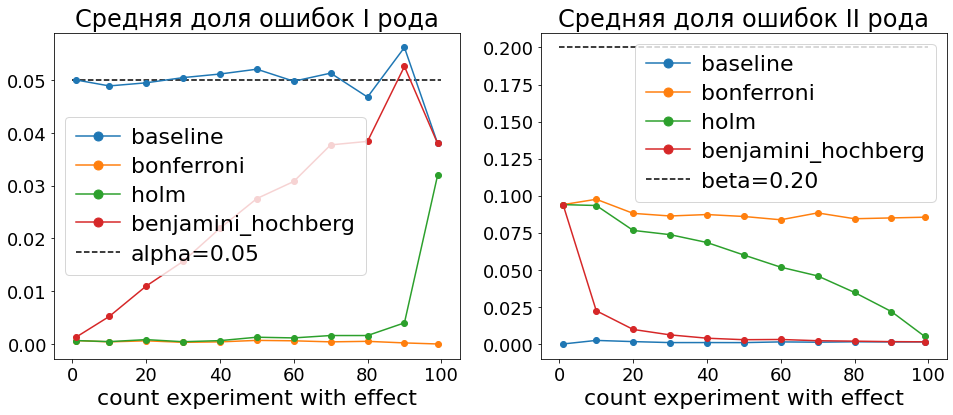

In [26]:
_, axes = plt.subplots(1, 2, figsize=(16, 6))
for error_name, title, ax in [['part_first_type_error', 'Средняя доля ошибок I рода', axes[0]], ['part_second_type_error', 'Средняя доля ошибок II рода', axes[1]]]:
    for method_name, dict_errors in dict_method_error.items():
        X = []
        Y = []
        for count_pilot_with_effect, dict_ in dict_errors.items():
            X.append(count_pilot_with_effect)
            count_pilot_ = count_pilot_with_effect if error_name == 'part_second_type_error' else count_pilots - count_pilot_with_effect
            Y.append(np.mean(dict_[error_name]))
        ax.plot(X, Y, '-o', label=method_name)
    if error_name == 'part_first_type_error':
        ax.hlines(0.05, 0, count_pilots, 'k', linestyles='--', label='alpha=0.05')
    else:
        ax.hlines(0.2, 0, count_pilots, 'k', linestyles='--', label='beta=0.20')
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('count experiment with effect')


Если рассматривать эксперименты по отдельности, то **baseline** контролирует ошибки на заданных уровнях. Ошибка второго рода меньше 0.2, так как размер эффекта больше MDE. Методы поправок на множественное тестирование уменьшают долю ошибок I рода и увеличивают долю ошибок II рода.

## 1.2. Большие выбросы
Больше экспериментов - больше вероятность больших выбросов.

Случайные выбросы могут быть больше ожидаемых эффектов.

Проведём 1000 АА-тестов, вычислим максимальный эффект. Повторим много раз, построим распределение максимальных эффектов.

In [27]:
np.random.seed(6)

group_size = 100
n_group = 100
n_iter = 10000

list_max_effect = []
for _ in tqdm(range(n_iter)):
    effects = []
    for _ in range(n_group):
        data_one = np.random.normal(100, 10, group_size)
        data_two = np.random.normal(100, 10, group_size)
        effect = (np.mean(data_two) / np.mean(data_one) - 1) * 100
        effects.append(effect)
    list_max_effect.append(np.max(effects))

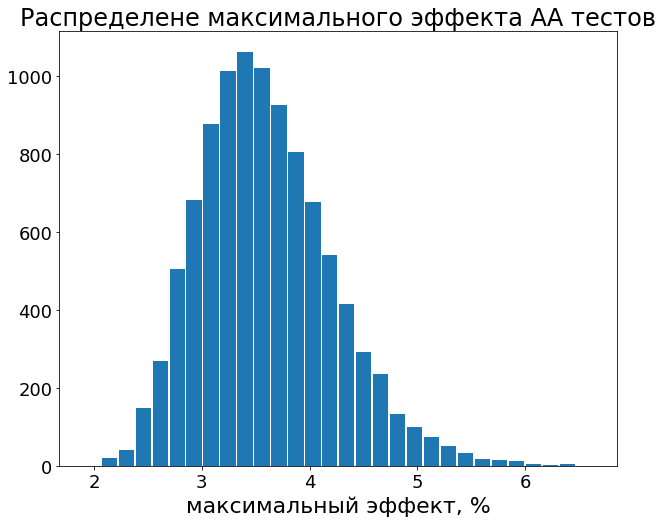

In [28]:
plt.hist(list_max_effect, bins=30, rwidth=0.9)
plt.title('Распределене максимального эффекта АА тестов')
plt.xlabel('максимальный эффект, %')
plt.savefig('graph_max_effect_aa.jpg', dpi=400)
plt.show()

Видно, что в большинстве случаев среди 1000 АА-тестах найдётся хотя бы один со случайным эффектом более 3%. Размер таких случайных эффектов может превышать 6%.

## 1.3. Выбросы случайны или нет.
Есть 20 зависимых экспериментов. Например, 100 метрик на одной паре групп.

Прокрасилось 5 метрик, случайность?

Можно построить распределение кол-ва прокрасившихся тестов при нулевой гипотезе и оценить 95 квантиль. Если прокрасилось тестов больше 95 квантиля, то на уровне значимости 0.05 можно сказать, что нулевая гипотеза неверна.

In [29]:
np.random.seed(6)

group_size = 50
n_metric = 20
n_iter = 10000
alpha = 0.05

random_mean = np.full(n_metric, 10)
random_cov = np.full((n_metric, n_metric), 2)
random_cov[np.arange(n_metric), np.arange(n_metric)] = 3

list_n_mark_metrics = []

for _ in tqdm(range(n_iter)):
    data_one = np.random.multivariate_normal(random_mean, random_cov, group_size)
    data_two = np.random.multivariate_normal(random_mean, random_cov, group_size)
    delta_mean = data_two.mean(axis=0) - data_one.mean(axis=0)
    pvalues = []
    for idx in range(n_metric):
        _, pvalue = stats.ttest_ind(data_one[:, idx], data_two[:, idx])
        pvalues.append(pvalue)
    pvalues = np.array(pvalues)
    n_mark_metrics = ((pvalues < alpha) * (delta_mean > 0)).sum()
    list_n_mark_metrics.append(n_mark_metrics)

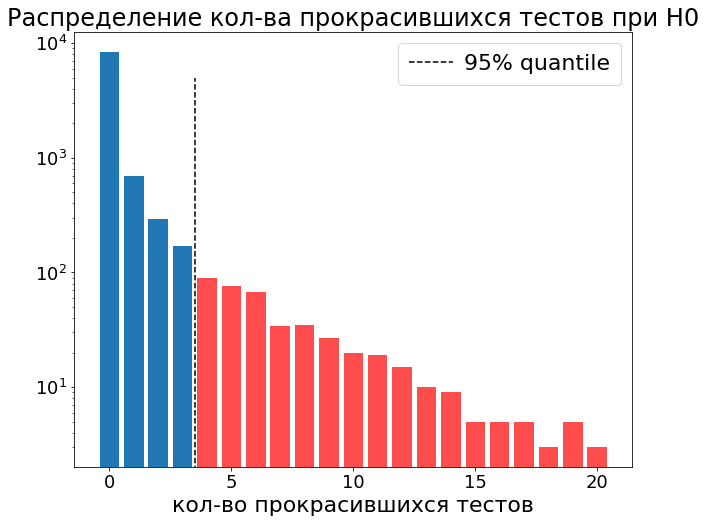

In [31]:
n_mark_count = pd.Series(list_n_mark_metrics, name='n').value_counts()
bound = np.percentile(list_n_mark_metrics, 95)
n_mark_count_lq_bound = n_mark_count[n_mark_count.index <= bound]
n_mark_count_ge_bound = n_mark_count[n_mark_count.index > bound]
plt.bar(n_mark_count_lq_bound.index, n_mark_count_lq_bound.values, log=True)
plt.bar(n_mark_count_ge_bound.index, n_mark_count_ge_bound.values, color='r', log=True, alpha=0.7)
plt.vlines(bound + 0.5, 0, n_iter / 2, color='k', linestyle='--', label='95% quantile')
plt.title('Распределение кол-ва прокрасившихся тестов при H0')
plt.xlabel('кол-во прокрасившихся тестов')
plt.legend()
plt.show()

В 5% случаях прокрашивается 4 и более метрик, когда эффекта нигде нет.

Значит при 5 прокрасившихся тестах нулевая гипотеза отвергается.

# 2. Распределение пилотов по пользователям.
Реализуем двойное хеширование

## 2.1. Вычисление остатка от деления по модулю хеш-функции.
Напишем функцию, которая будет считать хеш от строки и возвращать остаток от деления хеша по модулю.

Это нужно чтобы уметь распределять пользователей по группам с определёнными пилотами на лету.

In [32]:
def get_hash_modulo(value: str, modulo: int, salt: str = '0'):
    """Вычисляем остаток от деления: (hash(value) + salt) % modulo."""
    hash_value = int(hashlib.md5(str.encode(str(value) + str(salt))).hexdigest(), 16)
    return hash_value % modulo

Посмотрим как она работает

In [33]:
for i in range(10):
    hash_ = get_hash_modulo(f"{i}", 10, salt='salt_0')
    print(f'i={i}  hash={hash_}')

i=0  hash=7
i=1  hash=4
i=2  hash=3
i=3  hash=9
i=4  hash=6
i=5  hash=1
i=6  hash=2
i=7  hash=9
i=8  hash=1
i=9  hash=7


#### проверим равномерность распределения хеша от случайных чисел

In [35]:
str_values = np.random.normal(0, 1, 10000).astype(str)
print(f'example str_values:\n{str_values[:3]}')

hash_values = [get_hash_modulo(v, 100) for v in str_values]
print(f'example hash_values:\n{hash_values[:3]}')

example str_values:
['0.9016160722581291' '0.5044506189328469' '0.8687673264783623']
example hash_values:
[19, 45, 82]


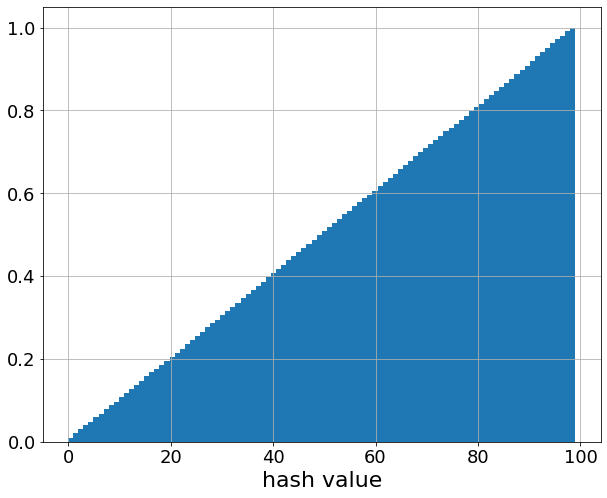

In [36]:
plt.hist(hash_values, bins=100, cumulative=True, density=True)
plt.grid()
plt.xlabel('hash value')
plt.show()

## 2.2. Распределение пилотов по слотам.
Слот - группа пользователей с одинаковым значением остатка от хеша.

Пусть будет 4 слота. Нужно раскидать 3 пилота, для каждого из которых нужно по 2 слота.

### 2.2.1. Независимые изменения.
Пилоты не влияют друг на друга. Будем распределять случайно.

In [37]:
def match_pilot_slot_one(pilots: list, slots: list):
    """Функция распределяет пилоты по слотам.
    
    pilots: список словарей, описывающих пилот. Содержит ключи:
        pilot_id - идентификатор пилота,
        count_slots - необходимое кол-во слотов.
    slots: список с идентификаторами слотов.
    
    return: словарь соответствия на каких слотах какие пилоты запускаются,
        {slot_id: list_pilot_id, ...}
    """
    slot_to_pilot = {slot: [] for slot in slots}
    for pilot in pilots:
        if pilot['count_slots'] > len(slots):
            print(f'ERROR: pilot_id={pilot["pilot_id"]} needs too many slots.')
            continue
        pilot_slots = np.random.choice(slots, pilot['count_slots'], False)
        for slot in pilot_slots:
            slot_to_pilot[slot].append(pilot['pilot_id'])
    return slot_to_pilot

In [38]:
pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2},
    {'pilot_id': 'pilot 2', 'count_slots': 2},
    {'pilot_id': 'pilot 3', 'count_slots': 2},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_one(pilots, slots)

{1: ['pilot 1', 'pilot 2'],
 2: ['pilot 3'],
 3: ['pilot 3'],
 4: ['pilot 1', 'pilot 2']}

### 2.2.2. Несовместные пилоты.
Не все изменения можно применять к одной группе пользователей. Будем распределять случайно, учитывая ограничения.

Добавим в описание пилотов атрибут, который будет содержать идентификаторы пилотов, с которыми они несовместны.

In [39]:
def match_pilot_slot_two(pilots: list, slots: list):
    """Функция распределяет пилоты по слотам.
    
    pilots: список словарей, описывающих пилот. Содержит ключи:
        pilot_id - идентификатор пилота,
        count_slots - необходимое кол-во слотов,
        conflict_pilots - list, идентификаторы несовместных пилотов.
    slots: список с идентификаторами слотов.
    
    return: словарь соответствия на каких слотах какие пилоты запускаются,
        {slot_id: list_pilot_id, ...}
    """
    slot_to_pilot = {slot: [] for slot in slots}
    pilot_to_slot = {pilot['pilot_id']: [] for pilot in pilots}
    for pilot in pilots:
        if pilot['count_slots'] > len(slots):
            print(f'ERROR: pilot_id={pilot["pilot_id"]} needs too many slots.')
            continue

        # найдём доступные слоты
        notavailable_slots = []
        for conflict_pilot_id in pilot['conflict_pilots']:
            notavailable_slots += pilot_to_slot[conflict_pilot_id]
        available_slots = list(set(slots) - set(notavailable_slots))
        
        if pilot['count_slots'] > len(available_slots):
            print(f'ERROR: pilot_id="{pilot["pilot_id"]}" not enough available slots.')
            continue

        pilot_slots = np.random.choice(available_slots, pilot['count_slots'], False)
        pilot_to_slot[pilot['pilot_id']] = list(pilot_slots)
        for slot in pilot_slots:
            slot_to_pilot[slot].append(pilot['pilot_id'])
    return slot_to_pilot

In [40]:
pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2, 'conflict_pilots': ['pilot 2']},
    {'pilot_id': 'pilot 2', 'count_slots': 2, 'conflict_pilots': ['pilot 1']},
    {'pilot_id': 'pilot 3', 'count_slots': 2, 'conflict_pilots': []},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_two(pilots, slots)

{1: ['pilot 1'],
 2: ['pilot 2', 'pilot 3'],
 3: ['pilot 1'],
 4: ['pilot 2', 'pilot 3']}

Если третий эксперимент нельзя проводить с первыми двумя, то, скорее всего его не получится разместить. Проверим это.

In [41]:
pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2, 'conflict_pilots': ['pilot 3']},
    {'pilot_id': 'pilot 2', 'count_slots': 2, 'conflict_pilots': ['pilot 3']},
    {'pilot_id': 'pilot 3', 'count_slots': 2, 'conflict_pilots': ['pilot 1', 'pilot 2']},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_two(pilots, slots)

ERROR: pilot_id="pilot 3" not enough available slots.


{1: ['pilot 2'], 2: ['pilot 1'], 3: [], 4: ['pilot 1', 'pilot 2']}

### 2.2.3. Сначала распределяем пилоты с наибольшим количеством конфликтов.
Попробуем изменить наш алгоритм, чтобы в ситуации, описанной выше, подбирались слоты для всех пилотов. Для этого будем в первую очередь распределять пилоты с наибольшим кол-вом конфликтов.

In [42]:
def match_pilot_slot_three(pilots: list, slots: list):
    """Функция распределяет пилоты по слотам.
    
    pilots: список словарей, описывающих пилот. Содержит ключи:
        pilot_id - идентификатор пилота,
        count_slots - необходимое кол-во слотов,
        conflict_pilots - list, идентификаторы несовместных пилотов.
    slots: список с идентификаторами слотов.
    
    return: словарь соответствия на каких слотах какие пилоты запускаются,
        {slot_id: list_pilot_id, ...}
    """
    pilots = sorted(pilots, key=lambda x: len(x['conflict_pilots']), reverse=True)
    
    slot_to_pilot = {slot: [] for slot in slots}
    pilot_to_slot = {pilot['pilot_id']: [] for pilot in pilots}
    for pilot in pilots:
        if pilot['count_slots'] > len(slots):
            print(f'ERROR: pilot_id={pilot["pilot_id"]} needs too many slots.')
            continue

        # найдём доступные слоты
        notavailable_slots = []
        for conflict_pilot_id in pilot['conflict_pilots']:
            notavailable_slots += pilot_to_slot[conflict_pilot_id]
        available_slots = list(set(slots) - set(notavailable_slots))
        
        if pilot['count_slots'] > len(available_slots):
            print(f'ERROR: pilot_id="{pilot["pilot_id"]}" not enough available slots.')
            continue

        pilot_slots = np.random.choice(available_slots, pilot['count_slots'], False)
        pilot_to_slot[pilot['pilot_id']] = list(pilot_slots)
        for slot in pilot_slots:
            slot_to_pilot[slot].append(pilot['pilot_id'])
    return slot_to_pilot

In [43]:
pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2, 'conflict_pilots': ['pilot 3']},
    {'pilot_id': 'pilot 2', 'count_slots': 2, 'conflict_pilots': ['pilot 3']},
    {'pilot_id': 'pilot 3', 'count_slots': 2, 'conflict_pilots': ['pilot 1', 'pilot 2']},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_three(pilots, slots)

{1: ['pilot 1', 'pilot 2'],
 2: ['pilot 3'],
 3: ['pilot 3'],
 4: ['pilot 1', 'pilot 2']}

Получилось, всем пилотом нашлось место.

Рассмотрим другой пример, когда наш алгоритм не будет распределять все пилоты по слотам, хотя это можно сделать.

Пусть у нас будет две группы пилотов, пилоты из одной группы можно запускать на одних и тех же слотах, а пилоты из разных групп запускать на одних слотах нельзя.

In [44]:
# две группы пилотов, которые не должны пересекаться
group_one = ['pilot 1', 'pilot 2', 'pilot 3']
group_two = ['pilot 4', 'pilot 5']

pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 2', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 3', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 4', 'count_slots': 2, 'conflict_pilots': group_one},
    {'pilot_id': 'pilot 5', 'count_slots': 2, 'conflict_pilots': group_one},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_three(pilots, slots)

ERROR: pilot_id="pilot 1" not enough available slots.
ERROR: pilot_id="pilot 2" not enough available slots.
ERROR: pilot_id="pilot 3" not enough available slots.


{1: ['pilot 4'], 2: ['pilot 5'], 3: [], 4: ['pilot 4', 'pilot 5']}

### 2.2.4. В первую очередь заполняем допустимые слоты, в которых уже есть пилоты.
Для решения прошлого кейса изменим наш алгоритм ещё раз. Будем в первую очередь назначать пилоты в доступные слоты, которые уже задействованы в других пилот.

In [45]:
def match_pilot_slot_four(pilots: list, slots: list):
    """Функция распределяет пилоты по слотам.
    
    pilots: список словарей, описывающих пилот. Содержит ключи:
        pilot_id - идентификатор пилота,
        count_slots - необходимое кол-во слотов,
        conflict_pilots - list, идентификаторы несовместных пилотов.
    slots: список с идентификаторами слотов.
    
    return: словарь соответствия на каких слотах какие пилоты запускаются,
        {slot_id: list_pilot_id, ...}
    """
    pilots = sorted(pilots, key=lambda x: len(x['conflict_pilots']), reverse=True)
    
    slot_to_pilot = {slot: [] for slot in slots}
    pilot_to_slot = {pilot['pilot_id']: [] for pilot in pilots}
    for pilot in pilots:
        if pilot['count_slots'] > len(slots):
            print(f'ERROR: pilot_id={pilot["pilot_id"]} needs too many slots.')
            continue

        # найдём доступные слоты
        notavailable_slots = []
        for conflict_pilot_id in pilot['conflict_pilots']:
            notavailable_slots += pilot_to_slot[conflict_pilot_id]
        available_slots = list(set(slots) - set(notavailable_slots))
        
        if pilot['count_slots'] > len(available_slots):
            print(f'ERROR: pilot_id="{pilot["pilot_id"]}" not enough available slots.')
            continue

        # shuffle - чтобы внести случайность, иначе они все упорядочены будут по номеру slot
        np.random.shuffle(available_slots)
        available_slots_orderby_count_pilot = sorted(
            available_slots,
            key=lambda x: len(slot_to_pilot[x]), reverse=True
        )
        pilot_slots = available_slots_orderby_count_pilot[:pilot['count_slots']]
        pilot_to_slot[pilot['pilot_id']] = pilot_slots
        for slot in pilot_slots:
            slot_to_pilot[slot].append(pilot['pilot_id'])
    return slot_to_pilot

In [46]:
# две группы пилотов, которые не должны пересекаться
group_one = ['pilot 1', 'pilot 2', 'pilot 3']
group_two = ['pilot 4', 'pilot 5']

pilots = [
    {'pilot_id': 'pilot 1', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 2', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 3', 'count_slots': 2, 'conflict_pilots': group_two},
    {'pilot_id': 'pilot 4', 'count_slots': 2, 'conflict_pilots': group_one},
    {'pilot_id': 'pilot 5', 'count_slots': 2, 'conflict_pilots': group_one},
]

slots = [i for i in range(1, 5)]

match_pilot_slot_four(pilots, slots)

{1: ['pilot 1', 'pilot 2', 'pilot 3'],
 2: ['pilot 4', 'pilot 5'],
 3: ['pilot 4', 'pilot 5'],
 4: ['pilot 1', 'pilot 2', 'pilot 3']}

Получили возможно распределение всех пилотов.